In [5]:
import xarray as xr
import numpy as np
import rioxarray  # Import rioxarray for GeoTIFF export
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2015-2044.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2A_98TMIN_counts_GT90F_2015-2044.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

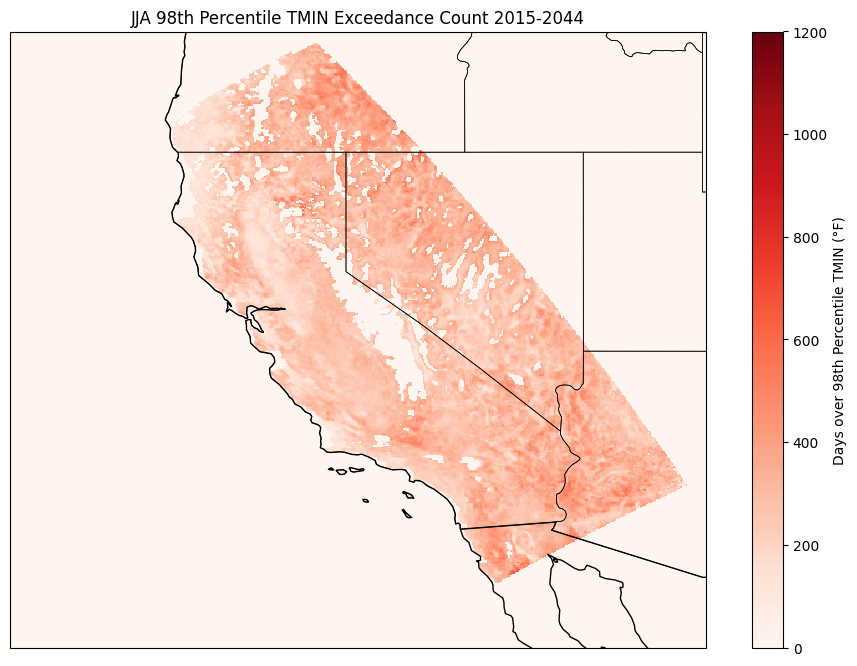

In [29]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200, cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2015-2044")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2A_98TMIN_counts_GT90F_2015-2044.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)

In [ ]:
def count_exceedances(file_path_data, file_path_percentiles):
    """
    Counts the number of days in JJA where daily tasmax exceeds the 98th percentile,
    but only if the 98th percentile value at that lat/lon location is greater than 305.4.

    Args:
        file_path_data (str): Path to the NetCDF file containing daily tasmax (e.g., "Test2.nc").
        file_path_percentiles (str): Path to the NetCDF file containing the pre-calculated 98th percentiles (e.g., "tasmax_98th_percentile.nc").

    Returns:
        xarray.DataArray: A DataArray with dimensions 'lat' and 'lon', containing
                            the count of exceedances. Returns None if there's an error.
    """
    try:
        ds_data = xr.open_dataset(file_path_data)
        ds_percentiles = xr.open_dataset(file_path_percentiles)
        ds_percentiles_mask = xr.open_dataset(file_path_percentiles_mask)

    except FileNotFoundError:
        print(f"Error: One or both files not found.")
        return None
    except Exception as e:
        print(f"Error opening dataset: {e}")
        return None

    # Select June, July, and August
    jja_mask = ds_data['time'].dt.month.isin([6, 7, 8])
    ds_jja = ds_data.sel(time=jja_mask)

    # Create a mask for locations where the 98th percentile is greater than 305.4
    percentile_mask = ds_percentiles_mask['tasmax'] > 305.4

    # Apply the mask to both the percentile and the daily data
    masked_percentiles = ds_percentiles['tasmax_minus_tasmax_minus_tasmin'].where(percentile_mask)

    # Compare daily tasmax with the masked 98th percentile values. Broadcasting is automatic.
    exceedances = ds_jja['tasmax_minus_tasmax_minus_tasmin'] > masked_percentiles

    # Count the number of exceedances at each location
    exceedance_counts = exceedances.groupby('time.dayofyear').sum().sum(dim='dayofyear')

    return exceedance_counts

file_path_data = "tasmin.ACCESS-CM2.ssp370.r1i1p1f1.2045-2074.LOCA2_CA_hybrid_v20230115.nc"  # Replace with your daily data file
file_path_percentiles = "VCP_EXHEAT_TMIN_98pct_1950-2014.nc"  # Replace with your percentile file
file_path_percentiles_mask = "VCP_EXHEAT_TMAX_98pct_1950-2014.nc"  # Replace with your percentile file

exceedance_counts = count_exceedances(file_path_data, file_path_percentiles)

if exceedance_counts is not None:
    print(exceedance_counts)

    # Save to NetCDF (optional)
    try:
        exceedance_counts.to_netcdf("VCP_EXHEAT_2B_98TMIN_counts_GT90F_2045-2074.nc")
        print("NetCDF file created successfully!")
    except Exception as e:
        print(f"Error exporting to NetCDF: {e}")

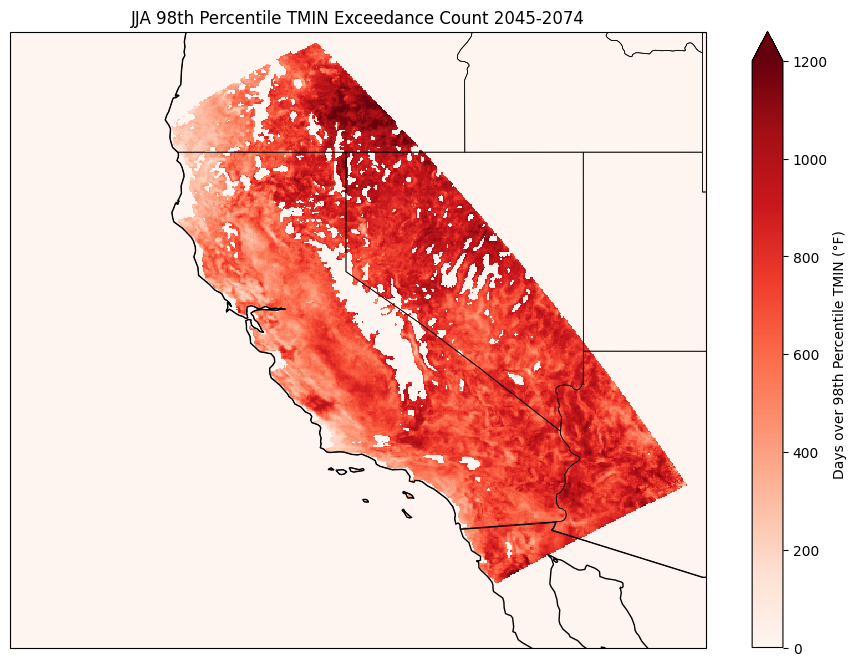

In [27]:
def map_98TMIN(netcdf_file, variable_name="tasmax_minus_tasmax_minus_tasmin", projection=ccrs.PlateCarree(), cmap='Reds'):
    """
    Creates a map of the Tasmin Exceedance Counts from a NetCDF file.

    Args:
        netcdf_file (str): Path to the NetCDF file containing the 100F counts.
        variable_name (str): Name of the variable to plot. Defaults to "tasmax".
        projection (cartopy.crs.Projection): Cartopy projection to use. Defaults to PlateCarree.
        cmap (str): Colormap to use. Defaults to 'RdBu_r'.
    """
    try:
        ds = xr.open_dataset(netcdf_file)
        data = ds[variable_name]

        if 'lat' not in data.coords or 'lon' not in data.coords:
            print("Error: Latitude and longitude coordinates not found.")
            ds.close()
            return

        fig = plt.figure(figsize=(12, 8))
        ax = plt.axes(projection=projection)

        ax.coastlines()
        ax.add_feature(cfeature.BORDERS)
        ax.add_feature(cfeature.STATES, linewidth=0.5)

        data.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=cmap,vmax=1200,cbar_kwargs={'label': 'Days over 98th Percentile TMIN (°F)'})

        plt.title("JJA 98th Percentile TMIN Exceedance Count 2045-2074")
        plt.show()

    except FileNotFoundError:
        print(f"Error: File not found at {netcdf_file}")
    except KeyError:
        print(f"Error: Variable '{variable_name}' not found in the file.")
    except Exception as e:
        print(f"An error occurred: {e}")
    finally:
        if 'ds' in locals():
            ds.close()

# Example usage (assuming you have the tasmax_diff.nc file from the previous code):
netcdf_file_path = "VCP_EXHEAT_2B_98TMIN_counts_GT90F_2045-2074.nc"  # Path to the NetCDF file with the tasmax difference

map_98TMIN(netcdf_file_path)